In [1]:
import requests
import pandas as pd
import numpy as np
from pprint import pprint
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pmaw import PushshiftAPI
import datetime as dt
import sklearn.feature_extraction.text as text
import statsmodels.api as sm
from sklearn.decomposition import PCA
import scipy as sc
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\plick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Generating Dataset

In [2]:
api = PushshiftAPI()

In [3]:
#convert date to epoch time 

start_time =  int(dt.datetime(2020,1,1,0,0).timestamp())
pol = "Politics"
LIMIT = 5000

submissions = api.search_submissions(subreddit=pol, 
                                     limit=LIMIT,
                                     after=start_time,
                                     score = ">1000",
                                     filter=['title', 'selftext', 'id' , 'subreddit', 'url', 'removed_by_category', 'score']
                                     )

submissions_df = pd.DataFrame(submissions)

4255 results available in Pushshift
Total:: Success Rate: 100.00% - Requests: 61 - Batches: 7 - Items Remaining: 0


In [4]:
post_id = list(submissions_df.id)

In [8]:
#get all the comments ids for our submissions
comment_ids = api.search_submission_comment_ids(ids=post_id)

comment_id_list = [c_id for c_id in comment_ids]
len(comment_id_list)

Total:: Success Rate: 100.00% - Requests: 5 - Batches: 1 - Items Remaining: 0


4255

In [9]:
#Take the comments ids and find the body. 
comments = api.search_comments(ids=comment_id_list,
                               limit=1000,
                               filter=['author', 'body', 'subreddit', 'id', 'link_id', 'score'])
df_comments = pd.DataFrame(comments)
df_comments

Total:: Success Rate: 100.00% - Requests: 5 - Batches: 1 - Items Remaining: 0


,author,body,id,link_id,score,subreddit
0,AutoModerator,"\nAs a reminder, this subreddit [is for civil ...",fnthyf0,t3_g3uijt,1,politics
1,SheriffComey,He's fucked them over a few times,fnti16r,t3_g3uijt,1,politics
2,WPPW,45 never intended on helping anyone but himsel...,fnti1r2,t3_g3uijt,1,politics
3,Cronchy_Tacos,Just ask the farmers how it's going for them.,fnti6mv,t3_g3uijt,1,politics
4,BlackOrre,Time for a quiz.\n\n\nMistreating your working...,fntibxg,t3_g3uijt,1,politics
...,...,...,...,...,...,...
4250,skiptomylou1231,Yeah link for anybody else who wants to see mo...,fi7ovo4,t3_f6wlzn,1,politics
4251,fnocoder,Them recent pardons was a signal to Stone,fi7ovqp,t3_f6wlzn,1,politics
4252,Lothire,Ah so exactly what Barr and Trump wanted.,fi7ovxw,t3_f6wlzn,1,politics
4253,BonusTurnip4Comrade,"Yikes! Where was that? He was brown, huh :'(",fi7owd5,t3_f6wlzn,1,politics


In [10]:
#grouping comments for each posts and concatenating them together
#One row per post, with that row con taining all the comments on that post. 

grouped_comments = df_comments.groupby('link_id').agg({'body': '\n'.join})
grouped_comments.head()

,body
link_id,
t3_f6wlzn,Lock him up!\nRoger Stone is trash. And is als...
t3_g3u98l,"\nAs a reminder, this subreddit [is for civil ..."
t3_g3uijt,"\nAs a reminder, this subreddit [is for civil ..."
t3_g3uwhu,"\nAs a reminder, this subreddit [is for civil ..."
t3_g3w2vl,"\nAs a reminder, this subreddit [is for civil ..."


In [13]:
# join the comments and the posts 
# set_index to join the id of the post with the link_id of the comment 

df_final = submissions_df.set_index('id').join(grouped_comments)

df_final.head()

,created_utc,score,selftext,subreddit,title,url,removed_by_category,body
id,,,,,,,,
f6wlzn,1582220467,1183,Roger J. Stone Jr. was sentenced Thursday to 4...,politics,Megathread: Roger Stone Sentenced to 40 months,https://www.reddit.com/r/politics/comments/f6w...,NaN,NaN
g3w2vl,1587247660,1134,,politics,DOJ Sent Bill Barr’s Anti-Mueller Talking Poin...,https://lawandcrime.com/high-profile/doj-sent-...,NaN,NaN
g3uwhu,1587243392,1054,,politics,U.S. doctor who cited Trump to push hydroxychl...,https://www.ctvnews.ca/health/coronavirus/u-s-...,NaN,NaN
g3uijt,1587242019,1095,,politics,Donald Trump Has Done Almost Nothing for the W...,https://www.motherjones.com/kevin-drum/2020/04...,NaN,NaN
g3u98l,1587241103,1953,,politics,Trump admin awards N95 contract far above norm...,https://www.salon.com/2020/04/18/trump-admin-a...,NaN,NaN


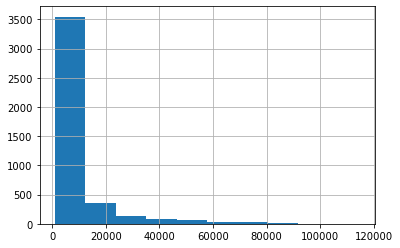

In [14]:
df_final.score.hist()

# Preprocessing

In [56]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
stemmer = PorterStemmer()

In [57]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [58]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    string = ' '.join(result)
    return string

In [59]:
df_final['title_pre'] = [preprocess(v) for v in df_final['title']]
df_final.head()

,created_utc,score,selftext,subreddit,title,url,removed_by_category,body,title_pre,compound,neg,neu,pos
id,,,,,,,,,,,,,
f6wlzn,1582220467,1183,Roger J. Stone Jr. was sentenced Thursday to 4...,politics,Megathread: Roger Stone Sentenced to 40 months,https://www.reddit.com/r/politics/comments/f6w...,NaN,NaN,megathread roger stone sentenc month,0.0000,0.000,1.000,0.000
g3w2vl,1587247660,1134,,politics,DOJ Sent Bill Barr’s Anti-Mueller Talking Poin...,https://lawandcrime.com/high-profile/doj-sent-...,NaN,NaN,send barr anti mueller talk point news barr co...,-0.3182,0.187,0.813,0.000
g3uwhu,1587243392,1054,,politics,U.S. doctor who cited Trump to push hydroxychl...,https://www.ctvnews.ca/health/coronavirus/u-s-...,NaN,NaN,doctor cite trump push miracl cure charg fed,0.0000,0.000,1.000,0.000
g3uijt,1587242019,1095,,politics,Donald Trump Has Done Almost Nothing for the W...,https://www.motherjones.com/kevin-drum/2020/04...,NaN,NaN,donald trump work middl class,0.0000,0.000,1.000,0.000
g3u98l,1587241103,1953,,politics,Trump admin awards N95 contract far above norm...,https://www.salon.com/2020/04/18/trump-admin-a...,NaN,NaN,trump admin award contract normal price bankru...,-0.0258,0.238,0.530,0.232


# Sentiment Analysis

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [20]:
analyzer = SentimentIntensityAnalyzer()

In [21]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return str(score)

In [22]:
df_final['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df_final['title_pre']]
df_final['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df_final['title_pre']]
df_final['neu'] = [analyzer.polarity_scores(v)['neu'] for v in df_final['title_pre']]
df_final['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df_final['title_pre']]
df_final

,created_utc,score,selftext,subreddit,title,url,removed_by_category,body,title_pre,compound,neg,neu,pos
id,,,,,,,,,,,,,
f6wlzn,1582220467,1183,Roger J. Stone Jr. was sentenced Thursday to 4...,politics,Megathread: Roger Stone Sentenced to 40 months,https://www.reddit.com/r/politics/comments/f6w...,NaN,NaN,megathread roger stone sentenc month,0.0000,0.000,1.000,0.000
g3w2vl,1587247660,1134,,politics,DOJ Sent Bill Barr’s Anti-Mueller Talking Poin...,https://lawandcrime.com/high-profile/doj-sent-...,NaN,NaN,send barr anti mueller talk point news barr co...,-0.3182,0.187,0.813,0.000
g3uwhu,1587243392,1054,,politics,U.S. doctor who cited Trump to push hydroxychl...,https://www.ctvnews.ca/health/coronavirus/u-s-...,NaN,NaN,doctor cite trump push miracl cure charg fed,0.0000,0.000,1.000,0.000
g3uijt,1587242019,1095,,politics,Donald Trump Has Done Almost Nothing for the W...,https://www.motherjones.com/kevin-drum/2020/04...,NaN,NaN,donald trump work middl class,0.0000,0.000,1.000,0.000
g3u98l,1587241103,1953,,politics,Trump admin awards N95 contract far above norm...,https://www.salon.com/2020/04/18/trump-admin-a...,NaN,NaN,trump admin award contract normal price bankru...,-0.0258,0.238,0.530,0.232
...,...,...,...,...,...,...,...,...,...,...,...,...,...
huccd4,1595208454,3141,,politics,"Trump says he may not accept election results,...",https://www.chicagotribune.com/election-2020/c...,NaN,NaN,trump say accept elect result defend confeder ...,0.3818,0.000,0.852,0.148
huc5k5,1595207701,5901,,politics,Trump's attack on Biden's mental fitness isn't...,https://www.independent.co.uk/us-election-2020...,NaN,NaN,trump attack biden mental fit land voter poll ...,-0.1531,0.246,0.556,0.198
hubyj1,1595206923,1594,,politics,This is the last week of $600 unemployment ben...,https://www.cnn.com/2020/07/19/politics/unempl...,NaN,NaN,week unemploy benefit,0.4588,0.000,0.400,0.600


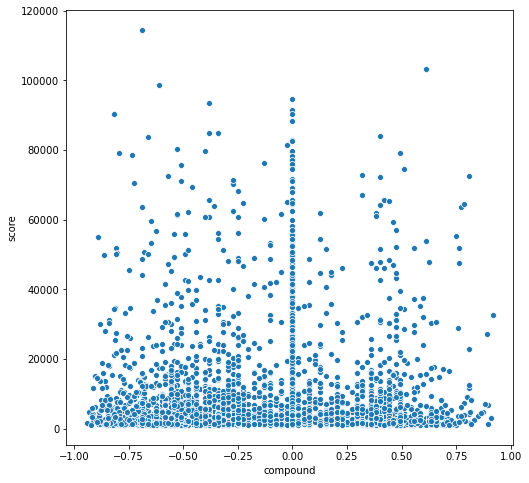

In [23]:
fig, ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x=df_final.compound, y=df_final.score)

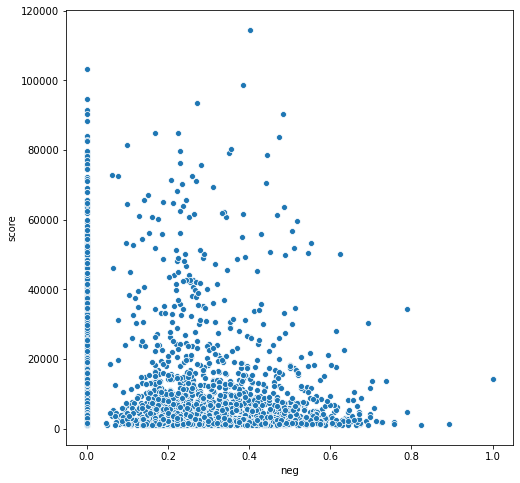

In [24]:
fig, ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x=df_final.neg, y=df_final.score)

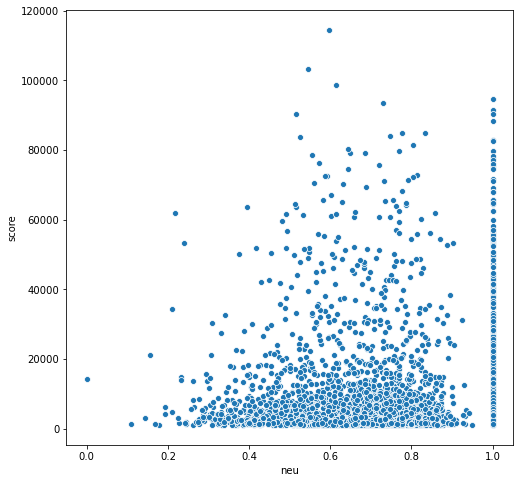

In [25]:
fig, ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x=df_final.neu, y=df_final.score)

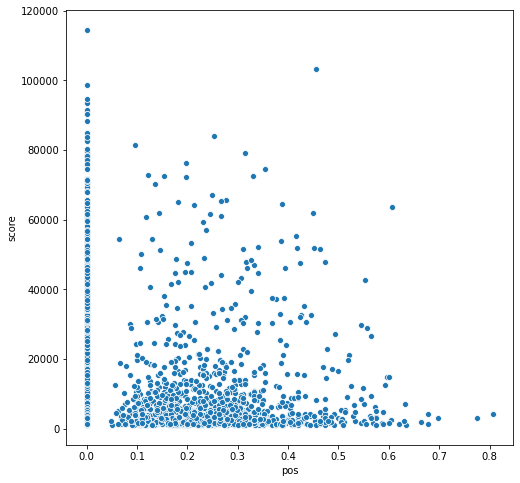

In [26]:
fig, ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x=df_final.pos, y=df_final.score)

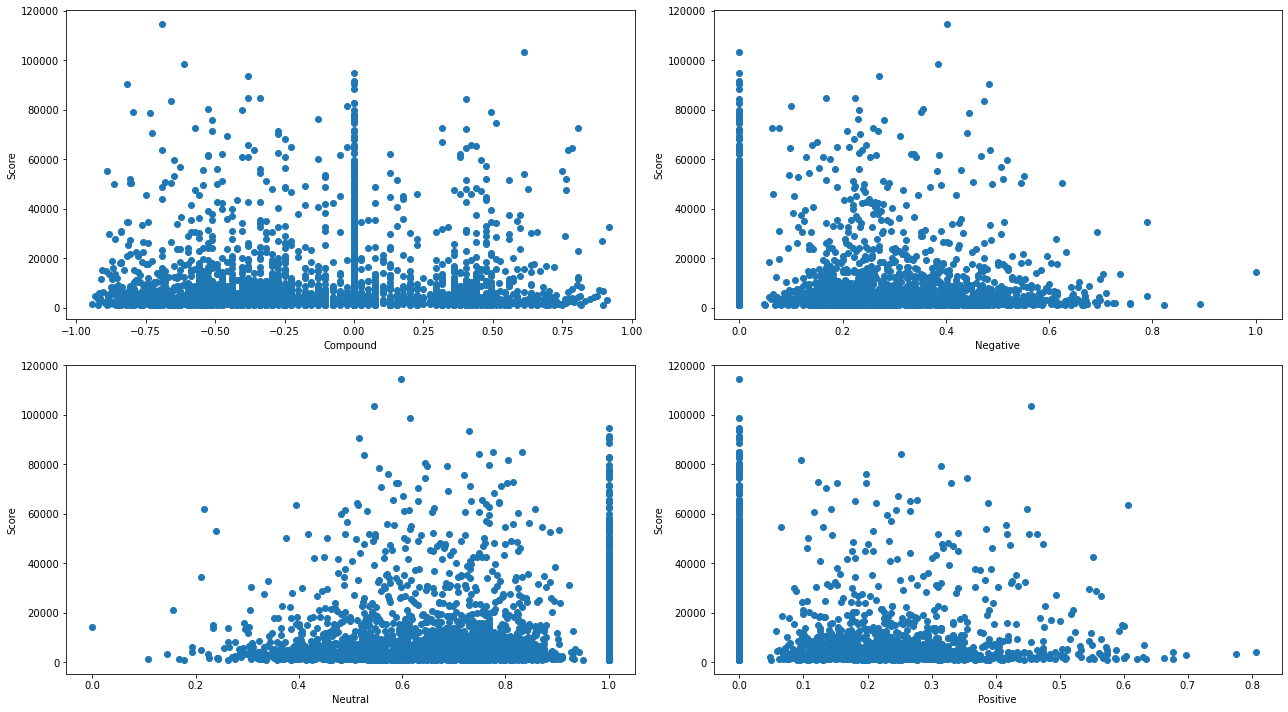

In [27]:
fig, axes = plt.subplots(2,2, figsize = (18,10))
for iter_, ax in enumerate(axes.flatten()):
    if iter_ == 0:
        ax.scatter(x=df_final.compound, y=df_final.score)
        ax.set_ylabel("Score")
        ax.set_xlabel("Compound")
    if iter_ == 1:
        ax.scatter(x=df_final.neg, y=df_final.score)
        ax.set_ylabel("Score")
        ax.set_xlabel("Negative")
    if iter_ == 2:
        ax.scatter(x=df_final.neu, y=df_final.score)
        ax.set_ylabel("Score")
        ax.set_xlabel("Neutral")
    if iter_ == 3:
        ax.scatter(x=df_final.pos, y=df_final.score)
        ax.set_ylabel("Score")
        ax.set_xlabel("Positive")
plt.tight_layout()

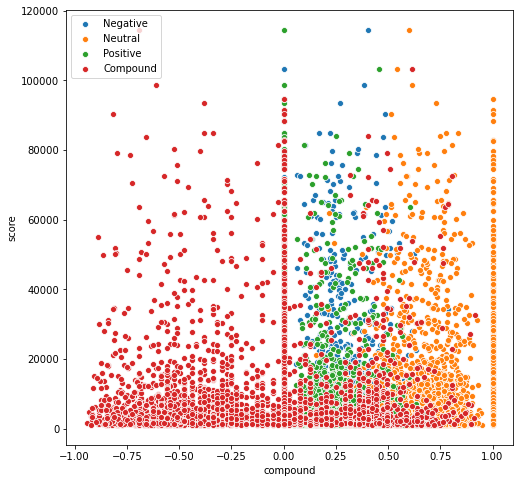

In [28]:
fig, ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x=df_final.neg, y=df_final.score)
sns.scatterplot(x=df_final.neu, y=df_final.score)
sns.scatterplot(x=df_final.pos, y=df_final.score)
sns.scatterplot(x=df_final.compound, y=df_final.score)
ax.legend(('Negative', 'Neutral', 'Positive', 'Compound'), loc='upper left')

In [29]:
x = df_final['compound']
X = sm.add_constant(x)
y = df_final['score']
xmin, xmax = X.min(), X.max()
est = sm.OLS(y, X).fit(cov_type = 'HC2')
Xfit = np.linspace(xmin, xmax, 100)
yfit = est.predict(sm.add_constant(X))
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.245
Date:                Wed, 17 Mar 2021   Prob (F-statistic):              0.265
Time:                        16:27:51   Log-Likelihood:                -46371.
No. Observations:                4255   AIC:                         9.275e+04
Df Residuals:                    4253   BIC:                         9.276e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8435.3817    213.983     39.421      0.000    8015.983    8854.781
compound     649.5543    582.216      1.116      0.265    -491.568    1790.676
==============================================================================
Omnibus:                     3007.982   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38237.856
Skew:                           3.359   Prob(JB):                         0.00
Kurtosis:                      16.059   Cond. No.                         2.77
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [30]:
x = df_final['neg']
X = sm.add_constant(x)
y = df_final['score']
xmin, xmax = X.min(), X.max()
est = sm.OLS(y, X).fit(cov_type = 'HC2')
Xfit = np.linspace(xmin, xmax, 100)
yfit = est.predict(sm.add_constant(X))
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8252
Date:                Wed, 17 Mar 2021   Prob (F-statistic):              0.364
Time:                        16:27:52   Log-Likelihood:                -46372.
No. Observations:                4255   AIC:                         9.275e+04
Df Residuals:                    4253   BIC:                         9.276e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8499.8264    256.990     33.074      0.000    7996.135    9003.518
neg         -943.9301   1039.093     -0.908      0.364   -2980.515    1092.655
==============================================================================
Omnibus:                     3007.754   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38207.108
Skew:                           3.359   Prob(JB):                         0.00
Kurtosis:                      16.052   Cond. No.                         5.62
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [31]:
x = df_final['neu']
X = sm.add_constant(x)
y = df_final['score']
xmin, xmax = X.min(), X.max()
est = sm.OLS(y, X).fit(cov_type = 'HC2')
Xfit = np.linspace(xmin, xmax, 100)
yfit = est.predict(sm.add_constant(X))
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3258
Date:                Wed, 17 Mar 2021   Prob (F-statistic):              0.568
Time:                        16:27:53   Log-Likelihood:                -46372.
No. Observations:                4255   AIC:                         9.275e+04
Df Residuals:                    4253   BIC:                         9.276e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8779.1062    763.316     11.501      0.000    7283.034    1.03e+04
neu         -541.6637    948.921     -0.571      0.568   -2401.514    1318.186
==============================================================================
Omnibus:                     3007.854   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38185.109
Skew:                           3.360   Prob(JB):                         0.00
Kurtosis:                      16.047   Cond. No.                         7.97
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [32]:
x = df_final['pos']
X = sm.add_constant(x)
y = df_final['score']
xmin, xmax = X.min(), X.max()
est = sm.OLS(y, X).fit(cov_type = 'HC2')
Xfit = np.linspace(xmin, xmax, 100)
yfit = est.predict(sm.add_constant(X))
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.640
Date:                Wed, 17 Mar 2021   Prob (F-statistic):             0.0565
Time:                        16:27:54   Log-Likelihood:                -46370.
No. Observations:                4255   AIC:                         9.274e+04
Df Residuals:                    4253   BIC:                         9.276e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8129.4393    230.227     35.310      0.000    7678.202    8580.677
pos         3052.5403   1599.957      1.908      0.056     -83.318    6188.398
==============================================================================
Omnibus:                     3009.398   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38319.705
Skew:                           3.361   Prob(JB):                         0.00
Kurtosis:                      16.075   Cond. No.                         7.59
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [33]:
num_cols = ['compound', 'neg', 'neu', 'pos']

X = df_final[num_cols].copy()

X = sm.add_constant(X)
y = df_final["score"]

for n in ['compound', 'neg','pos']:
    X[n+'2'] = X[n]**2

est = sm.OLS(y, X).fit(cov_type = 'HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.202
Date:                Wed, 17 Mar 2021   Prob (F-statistic):             0.0313
Time:                        16:27:54   Log-Likelihood:                -46365.
No. Observations:                4255   AIC:                         9.275e+04
Df Residuals:                    4247   BIC:                         9.280e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.522e+06   1.42e+06     -1.071      0.284   -4.31e+06    1.26e+06
compound    -313.1533   1897.698     -0.165      0.869   -4032.572    3406.266
neg         1.533e+06   1.42e+06      1.079      0.281   -1.25e+06    4.32e+06
neu          1.53e+06   1.42e+06      1.076      0.282   -1.26e+06    4.32e+06
pos         1.533e+06   1.42e+06      1.078      0.281   -1.25e+06    4.32e+06
compound2   3705.7651   1922.636      1.927      0.054     -62.533    7474.063
neg2       -1.534e+04   6442.107     -2.381      0.017    -2.8e+04   -2709.575
pos2       -3665.1346   9274.800     -0.395      0.693   -2.18e+04    1.45e+04
==============================================================================
Omnibus:                     2999.953   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37939.542
Skew:                           3.349   Prob(JB):                         0.00
Kurtosis:                      16.005   Cond. No.                     1.45e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# TF-IDF

OLS R^2:  0.012408937131829001


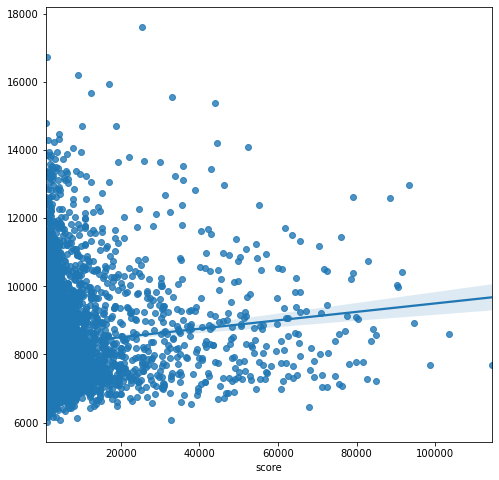

In [60]:
def plot_tfidf(CS, ax=None):
    fig, ax = plt.subplots(figsize = (8,8))
    COMPRESSED_SIZE = CS

    tf = text.TfidfVectorizer(stop_words='english')
    X = tf.fit_transform(df_final['title_pre'])

    Xd = X.toarray()
    Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
    Xd = sm.add_constant(Xd)
    
    pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df_final['score'].values
    print("OLS R^2: ", r2_score(df_final['score'], pred))
    
    sns.regplot(x="score", y=pred, data=df_final);
plot_tfidf(10)

In [35]:
from ipywidgets import interact, fixed
interact(plot_tfidf, CS=[100, 200, 300, 400], ax=fixed(None));

interactive(children=(Dropdown(description='CS', options=(100, 200, 300, 400), value=100), Output()), _dom_cla…

In [36]:
COMPONENTS = 400

tf = text.TfidfVectorizer(stop_words='english')
X = tf.fit_transform(df_final['title_pre'])
pca = PCA(n_components = COMPONENTS)
X = pca.fit(X.todense().T).components_.T
X = sm.add_constant(X)
X

array([[ 1.00000000e+00,  1.88849325e-03, -1.69197291e-03, ...,
        -8.98955849e-03, -2.21454317e-02, -9.59809718e-05],
       [ 1.00000000e+00,  9.13014504e-03, -1.03236395e-02, ...,
         6.91814166e-03,  1.14701849e-03,  7.38973906e-03],
       [ 1.00000000e+00,  1.03054481e-02, -9.16595219e-03, ...,
         3.38069406e-03,  2.92163936e-03,  1.46711224e-02],
       ...,
       [ 1.00000000e+00,  2.73143769e-03, -9.78194990e-04, ...,
         2.88487359e-03,  8.68716122e-03,  4.94612795e-03],
       [ 1.00000000e+00,  9.69585492e-03, -3.36198477e-02, ...,
         2.29247126e-02,  1.81120017e-02,  1.43191428e-02],
       [ 1.00000000e+00,  1.46394883e-02, -7.10871815e-03, ...,
         9.69738820e-03,  4.89375281e-03, -3.00788043e-02]])

In [37]:
sm.OLS(df_final.score.values, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.364
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           5.98e-06
Time:                        16:28:08   Log-Likelihood:                -46090.
No. Observations:                4255   AIC:                         9.298e+04
Df Residuals:                    3854   BIC:                         9.553e+04
Df Model:                         400                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5828.7036    554.287     10.516      0.000    4741.980    6915.427
x1          1.669e+05   3.31e+04      5.037      0.000    1.02e+05    2.32e+05
x2          5.738e+04   1.29e+04      4.456      0.000    3.21e+04    8.26e+04
x3         -3.043e+04   1.42e+04     -2.142      0.032   -5.83e+04   -2576.406
x4          -1.54e+04    1.3e+04     -1.188      0.235   -4.08e+04       1e+04
x5          2.515e+04    1.3e+04      1.933      0.053    -358.089    5.07e+04
x6         -8403.2015   1.29e+04     -0.651      0.515   -3.37e+04    1.69e+04
x7          3903.1188   1.29e+04      0.303      0.762   -2.13e+04    2.91e+04
x8         -2.696e+04    1.3e+04     -2.077      0.038   -5.24e+04   -1514.388
x9          4.017e+04   1.29e+04      3.120      0.002    1.49e+04    6.54e+04
x10          296.0616   1.29e+04      0.023      0.982   -2.49e+04    2.55e+04
x11         3439.9007   1.31e+04      0.262      0.793   -2.23e+04    2.91e+04
x12         1.571e+04   1.29e+04      1.221      0.222   -9524.013     4.1e+04
x13          1.99e+04   1.29e+04      1.543      0.123   -5384.187    4.52e+04
x14          734.7914   1.29e+04      0.057      0.954   -2.45e+04     2.6e+04
x15         6255.9804   1.29e+04      0.485      0.627    -1.9e+04    3.15e+04
x16         1.115e+04    1.3e+04      0.861      0.389   -1.42e+04    3.65e+04
x17         9971.0613    1.3e+04      0.765      0.444   -1.56e+04    3.55e+04
x18        -3.108e+04   1.29e+04     -2.410      0.016   -5.64e+04   -5791.893
x19         3.301e+04   1.29e+04      2.565      0.010    7775.773    5.82e+04
x20         2.889e+04   1.29e+04      2.243      0.025    3640.859    5.41e+04
x21         1411.3990   1.32e+04      0.107      0.915   -2.44e+04    2.72e+04
x22        -9085.4024   1.29e+04     -0.704      0.481   -3.44e+04    1.62e+04
x23        -1500.5793   1.29e+04     -0.116      0.907   -2.68e+04    2.38e+04
x24         1.743e+04   1.29e+04      1.351      0.177   -7859.547    4.27e+04
x25        -1.246e+04   1.31e+04     -0.950      0.342   -3.82e+04    1.33e+04
x26         -3.58e+04    1.3e+04     -2.744      0.006   -6.14e+04   -1.02e+04
x27        -5537.7317    1.3e+04     -0.426      0.670    -3.1e+04    1.99e+04
x28         1.361e+04   1.29e+04      1.058      0.290   -1.16e+04    3.88e+04
x29         7862.0966   1.29e+04      0.610      0.542   -1.74e+04    3.31e+04
x30         5132.0840   1.29e+04      0.399      0.690   -2.01e+04    3.04e+04
x31         7449.4828   1.29e+04      0.578      0.563   -1.78e+04    3.27e+04
x32         1.471e+04   1.29e+04      1.139      0.255   -1.06e+04       4e+04
x33        -1.863e+04   1.29e+04     -1.447      0.148   -4.39e+04    6611.645
x34         1.841e+04   1.29e+04      1.422      0.155   -6972.685    4.38e+04
x35         1.117e+04   1.29e+04      0.868      0.386   -1.41e+04    3.64e+04
x3

In [38]:
from sklearn.cluster import KMeans

kmc = KMeans(n_clusters = 2)
kmc.fit(X)
kmc.predict(X)

array([1, 1, 1, ..., 1, 1, 1])

In [39]:
fowlkes_mallows_score(df_final.score, kmc.predict(X))

0.011766942104758996

# Sentence Embedding

In [40]:
import gensim.downloader as model_api

word_vectors = model_api.load("glove-wiki-gigaword-50")

In [42]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

In [43]:
rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

In [44]:
words = (
    df_final.title_pre
    .str.lower()
    .str.replace(pattern, replacer)
    .str.split()
)

In [45]:
words = pd.DataFrame(words.tolist())

In [46]:
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)

def map_vectors(row):
    if np.sum(row.notna()) == 0:
        return np.zeros(word_vectors.vector_size)
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)

emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())

In [47]:
X = emb.to_numpy()
ss = StandardScaler()
ss.fit(X.T)
X = ss.transform(X.T)
X = X.T
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.236465,1.305105,0.227308,0.244338,0.848357,-0.128057,-1.209868,0.538648,-0.740995,-0.256316,...,0.086519,0.692584,-0.342159,-0.183140,0.985189,0.163328,-0.761526,-1.155386,-1.095128,-0.091818
1,0.307465,-0.494521,0.868406,0.449996,0.404658,0.051021,-1.036315,0.239509,-0.225151,-0.671207,...,0.801295,1.239398,-0.057198,-0.117629,0.867039,0.403549,-0.362170,1.351871,-0.388439,1.559509
2,1.040672,-0.246331,0.285215,-1.326809,-0.996933,-0.140690,-0.127828,-0.195618,0.577430,1.546485,...,-0.698020,0.106793,-0.209198,1.169152,1.254461,0.114760,0.676377,0.349074,0.554078,0.501394
3,0.075742,1.000563,-0.278227,0.324098,0.675072,0.305583,-0.724323,-1.331443,-1.152941,-0.613256,...,-0.501409,0.231416,0.496063,0.995251,-0.350116,0.350111,-0.576929,-0.759321,0.059013,1.467697
4,-0.175578,0.411651,0.548780,0.600359,0.236180,-0.020927,-0.832815,-0.612863,0.383808,0.197756,...,-0.294985,-0.454250,0.158715,0.390977,-1.245680,-0.302534,-0.630421,1.004382,0.397006,1.141060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,0.470674,-0.103025,0.410428,0.016365,0.434824,-0.892143,-0.417717,0.059166,-0.416209,-0.280919,...,-0.078550,0.782738,-0.042885,0.484377,0.236239,0.367210,-0.979384,1.218883,0.605007,0.590327
4251,0.794652,0.193336,1.000116,0.151399,0.679279,0.735564,-0.792322,-0.089573,0.024030,-0.535722,...,-0.427131,0.134209,-0.267632,0.854711,-0.308070,-0.046710,-0.631743,0.459270,1.100572,0.553390
4252,0.671065,0.333203,0.022535,0.056557,0.072690,-0.072027,-1.303171,0.182669,0.452600,0.350168,...,-1.253853,-0.057971,0.080351,0.205377,0.107074,-0.128931,-0.744614,1.144622,-0.419498,0.598683
4253,-0.199893,0.796469,-0.237713,-0.282049,0.596534,0.759759,-0.766798,-0.414743,0.004830,0.267500,...,-0.335532,0.038005,-0.079633,0.567884,1.284450,0.313093,-0.419805,-0.823567,0.279789,-0.187073


In [48]:
sm.OLS(df_final.score, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.675
Date:                Wed, 17 Mar 2021   Prob (F-statistic):            0.00231
Time:                        16:29:14   Log-Likelihood:                -46331.
No. Observations:                4255   AIC:                         9.276e+04
Df Residuals:                    4205   BIC:                         9.308e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4824.6945   1462.843      3.298      0.001    1956.749    7692.640
x1          -858.9925    892.043     -0.963      0.336   -2607.867     889.883
x2          -117.3672    975.816     -0.120      0.904   -2030.482    1795.747
x3            21.1998   1160.340      0.018      0.985   -2253.680    2296.079
x4           -47.9139    932.848     -0.051      0.959   -1876.789    1780.961
x5          1899.9141   1049.372      1.811      0.070    -157.410    3957.238
x6          1443.8000    621.528      2.323      0.020     225.277    2662.323
x7         -1966.8665   1461.677     -1.346      0.178   -4832.527     898.794
x8           521.4771    999.075      0.522      0.602   -1437.238    2480.193
x9           121.7148    648.273      0.188      0.851   -1149.243    1392.673
x10         3531.8517   1298.707      2.720      0.007     985.699    6078.004
x11        -3095.2639   2199.224     -1.407      0.159   -7406.904    1216.376
x12          183.3708   1689.659      0.109      0.914   -3129.253    3495.994
x13        -1797.0447   1646.999     -1.091      0.275   -5026.033    1431.943
x14        -1540.7345    987.092     -1.561      0.119   -3475.956     394.487
x15        -2037.9577   1376.062     -1.481      0.139   -4735.766     659.850
x16         1665.4656   1376.750      1.210      0.226   -1033.691    4364.623
x17        -1741.9871   1073.490     -1.623      0.105   -3846.594     362.620
x18         -857.7368   1661.205     -0.516      0.606   -4114.575    2399.102
x19        -1058.0865   1079.450     -0.980      0.327   -3174.378    1058.205
x20         -572.8480   1146.706     -0.500      0.617   -2820.997    1675.301
x21         -136.4204   1128.423     -0.121      0.904   -2348.725    2075.884
x22        -2276.7178   1831.427     -1.243      0.214   -5867.283    1313.847
x23         1048.4197   1267.058      0.827      0.408   -1435.684    3532.523
x24          977.2975   1672.312      0.584      0.559   -2301.318    4255.913
x25         1524.8845   1829.734      0.833      0.405   -2062.360    5112.129
x26          356.3303   1764.366      0.202      0.840   -3102.760    3815.421
x27            5.7236    544.132      0.011      0.992   -1061.062    1072.510
x28         1926.7229   1820.736      1.058      0.290   -1642.882    5496.328
x29        -2510.9529   1175.325     -2.136      0.033   -4815.211    -206.694
x30         1520.0720   1191.442      1.276      0.202    -815.784    3855.928
x31          189.3687    799.859      0.237      0.813   -1378.777    1757.515
x32         1020.8605    933.858      1.093      0.274    -809.994    2851.715
x33        -2586.4271   1566.677     -1.651      0.099   -5657.942     485.087
x34          736.4504   1026.496      0.717      0.473   -1276.023    2748.924
x35         -428.4263   1585.207     -0.270      0.787   -3536.270    2679.417
x3

In [49]:
kmc = KMeans(n_clusters = 2)
kmc.fit(X)
kmc.predict(X)
fowlkes_mallows_score(df_final.score, kmc.predict(X))

0.00927658167897245